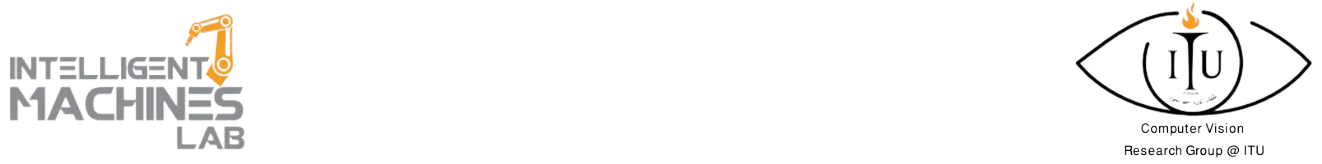

## Generative AI & LLM Fall 2024
## Assignment 2: Implementing a VAE using CNN and pytorch

In this assignment, you will implement a VAE using CNN and pytorch. You will use the MNIST dataset for this assignment.

**You will need to implement the following:**

1. The VAE Model
2. Kaiming Initialization also known as He Initialization (https://paperswithcode.com/method/he-initialization)
3. The VAE loss function
4. The forward pass
5. The training loop
6. The evaluation loop
7. The sampling loop
8. Visualize the latent space


**Guidelines:**

1. Use this notebook as a template to implement the VAE model.
2. Try your best to avoid using ChatGPT or any other LLM to complete this assignment.
3. If you get stuck, please reach out at `manzoor.rohan97@gmail.com`
4. Ensure proper formatting of the code.
5. While you will be implementing the assignment on Colab, you are also required to upload the project to github and share the link with us.


**The assignment will be evaluated based on the following criteria:**

| Criteria                | Marks |
|-------------------------|-------|
| 1. VAE model            | 2.5   |
| 2. Training Loop        | 2.5   |
| 3. Correct Sampling     | 2.0   |
| 4. Viva                 | 3.0   |
| Total                   | 10.0  |


Name: `Ghufran Nazir`

Reg No: `BSCS21027`

Github Link: `https://github.com/ghufran1054/genAI_asm2`

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init


from torchvision import datasets, transforms
import torch.optim as optim

In [3]:
torch.__version__

'2.4.0'

# Model Definition

In [4]:
def weights_init(m):
    # Use He Initialization and use this function to initialize the weights of the model
    init.kaiming_normal_(m.weight.data)
    if m.bias is not None:
        init.constant_(m.bias.data, 0)
    

class CNN_VAE(nn.Module):
    def __init__(self, input_channels=1, h_dims=[32, 64], latent_dims=2):
        """
        Initializes the CNN_VAE model.

        Args:
            input_channels (int): Number of input channels (e.g., 1 for grayscale images).
            h_dims (list): A list defining the number of output channels for each convolutional layer in the encoder.
            latent_dims (int): Dimensionality of the latent space.
        """
        super(CNN_VAE, self).__init__()

        
        # You encoder will have 2 convolutional layers, a fixed kernel size of 3, stride of 2, padding of 1
        # The output of the encoder will be flattened to a single vector
        # 28x28x1 -> 14x14x32 -> 7x7x64
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=h_dims[0], kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=h_dims[0], out_channels=h_dims[1], kernel_size=3, stride=2, padding=1)
        

        # Initialize the FC layers to output the mean and log variance
        self.fc_mean = nn.Linear(h_dims[1]*7*7, latent_dims)
        self.fc_logvar = nn.Linear(h_dims[1]*7*7, latent_dims)



        # Initialize the decoder layers
        # The decoder will have 2 transposed convolutional layers, a fixed kernel size of 3, stride of 2, padding of 1
        # The output of the decoder will be a tensor of the same size as the input
        # 7x7x64 -> 14x14x32 -> 28x28x1
        self.fc_decoder = nn.Linear(latent_dims, h_dims[1]*7*7)
        self.deconv1 = nn.ConvTranspose2d(in_channels=h_dims[1], out_channels=h_dims[0], kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels=h_dims[0], out_channels=input_channels, kernel_size=3, stride=2, padding=1, output_padding=1)


        # Apply weight initialization using the weights_init function
        self.apply(weights_init)

    def reparametrize(self, mu, logvar):
        """
        Reparameterization trick to sample from the latent space.

        Args:
            mu (torch.Tensor): Mean of the latent distribution.
            logvar (torch.Tensor): Log variance of the latent distribution.

        Returns:
            torch.Tensor: Sampled latent variable from the distribution defined by mu and logvar.
        """
        # Implement the reparametrization trick. Notice the input argument is logvar and not sigma. Can you guess why?
        std_dev = torch.exp(logvar / 2)
        eps = torch.randn_like(std_dev)
        return mu + eps*std_dev
        

    def encode(self, x):
        """
        Encodes the input data into the latent space representation.

        Args:
            x (torch.Tensor): Input data (e.g., images) to be encoded.

        Returns:
            tuple: A tuple containing:
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        # Implement the encoding process
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        # Flatten the output of the convolutional layers
        x = x.view(x.size(0), -1)
        mu = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        """
        Decodes the latent representation back to the original data space.

        Args:
            z (torch.Tensor): Latent representation to be decoded.

        Returns:
            torch.Tensor: Reconstructed data from the latent representation.
        """
        # Implement the decoding process
        z = F.relu(self.fc_decoder(z))
        z = z.view(z.size(0), 64, 7, 7)
        z = F.relu(self.deconv1(z))
        z = torch.sigmoid(self.deconv2(z))
        return z



    def forward(self, x):
        """
        Forward pass through the model.

        Args:
            x (torch.Tensor): Input data (e.g., images) for reconstruction.

        Returns:
            tuple: A tuple containing:
                - x_reconstructed (torch.Tensor): Reconstructed input data.
                - mu (torch.Tensor): Mean of the latent distribution.
                - logvar (torch.Tensor): Log variance of the latent distribution.
        """
        # Implement the forward pass
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, logvar

# Usage
INPUT_CHANNELS = 1
INPUT_SIZE = 28
model = CNN_VAE(input_channels=INPUT_CHANNELS)
output, mu, logvar = model.forward(torch.randn((1, INPUT_CHANNELS, INPUT_SIZE, INPUT_SIZE)))
print(output.shape)

torch.Size([1, 1, 28, 28])


# Dataset Loading

In [37]:
# Hyper-parameters
# you can change these to see how the model performs
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_DIMS = 1
HID_DIMS = [32, 64]
Z_DIMS = 10
NUM_EPOCHS = 5
LR = 3e-4
BATCH_SIZE = 64
VAL_AFTER = 938
print(DEVICE)

cpu


In [6]:
# Loading dataset

# Load the MNIST dataset and prepare the dataloaders.
# You can use the torchvision.datasets.MNIST and torch.utils.data.DataLoader to load the dataset.
# You will need separate daataloader for train and test set

# Define the transformations to be applied to the input data
transform = transforms.Compose([transforms.ToTensor()])
# Load the training and test datasets
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
# Create the dataloaders for the training and test datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
from matplotlib import pyplot as plt
from torchvision.utils import make_grid

def plot_image(img, nrow=10):
    plt.figure(figsize=(10, 6))
    plt.imshow(make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy())
    plt.axis('off')
    plt.show()

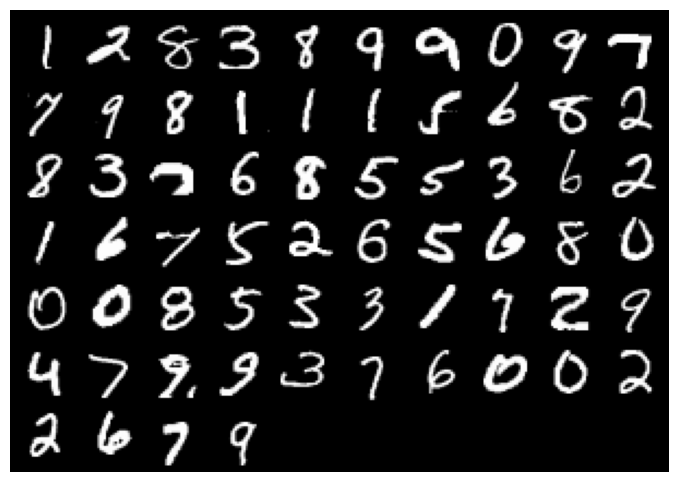

In [8]:
# Use the plot_image function to plot the images
images, _ = next(iter(train_loader))
plot_image(images)

# Training Loop

In [9]:
# Define VAE loss
def vae_loss(reconstructed_x, x, mu, logvar):
    # Implement the VAE loss function
    # The loss consists of two terms: the reconstruction loss and the KL divergence
    # Use MSE loss for the reconstruction loss
    # The KL divergence is the KL divergence between the latent distribution and the standard normal distribution

    # # Compute Mean Squared Error loss
    MSE = F.mse_loss(reconstructed_x, x, reduction='sum')

    # Use Binary Cross Entropy loss for the reconstruction loss
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')

    # Compute the KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return MSE + KLD
    return BCE + KLD


In [38]:
from tqdm import tqdm

# Instructions:
# 1. Initialize the model and the optimizer. You will be using Adam optimizer
# 2. Implement a training loop that iterates over the training data, performs forward and backward passes, and updates the model parameters.
# 3. Implement a validation loop that evaluates the model on the validation data.
# 4. Implement a progress bar to visualize the training progress.
# 5. Store your training and validation losses in train_losses and eval_losses respectively.
def evaluate_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        eval_losses_epoch = []
        for images, _ in test_loader:
            images = images.to(DEVICE)
            reconstructed_images, mu, logvar = model(images)
            loss = vae_loss(reconstructed_images, images, mu, logvar)
            eval_losses_epoch.append(loss.item())
    model.train()
    return eval_losses_epoch

model = CNN_VAE(INPUT_DIMS, HID_DIMS, Z_DIMS).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

model.train()

# Training Loop
train_losses = []
eval_losses = []
for epoch in range(NUM_EPOCHS):

    # Implement the training loop
    train_losses_epoch = []
    for i, (images, _) in enumerate(tqdm(train_loader)):
        images = images.to(DEVICE)
        optimizer.zero_grad()
        reconstructed_images, mu, logvar = model(images)
        loss = vae_loss(reconstructed_images, images, mu, logvar)
        loss.backward()
        optimizer.step()
        train_losses_epoch.append(loss.item())

        # Implement the evaluation loop
        if (i+1) % VAL_AFTER == 0:
            eval_losses_epoch = evaluate_model(model, test_loader)
            eval_losses.append(sum(eval_losses_epoch)/len(eval_losses_epoch))
            train_losses.append(sum(train_losses_epoch)/len(train_losses_epoch))

            print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Step {i+1}/{len(train_loader)}, Train Loss: {train_losses[-1]:.4f}, Eval Loss: {eval_losses[-1]:.4f}")


100%|██████████| 938/938 [00:56<00:00, 16.60it/s]


Epoch 1/5, Step 938/938, Train Loss: 3916.5734, Eval Loss: 3205.3541


100%|██████████| 938/938 [00:57<00:00, 16.43it/s]


Epoch 2/5, Step 938/938, Train Loss: 3105.1105, Eval Loss: 3007.9588


100%|██████████| 938/938 [00:56<00:00, 16.52it/s]


Epoch 3/5, Step 938/938, Train Loss: 2948.3217, Eval Loss: 2876.3881


100%|██████████| 938/938 [00:56<00:00, 16.51it/s]


Epoch 4/5, Step 938/938, Train Loss: 2855.2315, Eval Loss: 2822.2420


100%|██████████| 938/938 [00:56<00:00, 16.55it/s]

Epoch 5/5, Step 938/938, Train Loss: 2798.5918, Eval Loss: 2759.5251


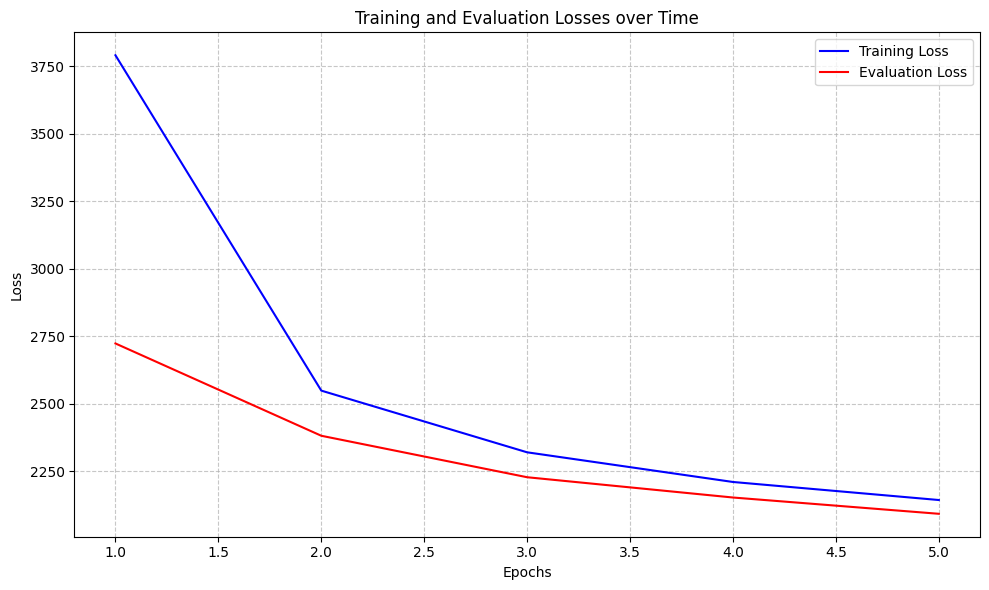

In [23]:
# Visualize your losses as your training progresses
plt.figure(figsize=(10, 6))
x = list(range(1, NUM_EPOCHS+1))
plt.plot(x, train_losses, label='Training Loss', color='blue')
plt.plot(x, eval_losses, label='Evaluation Loss', color='red')
plt.title('Training and Evaluation Losses over Time')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Visualizations

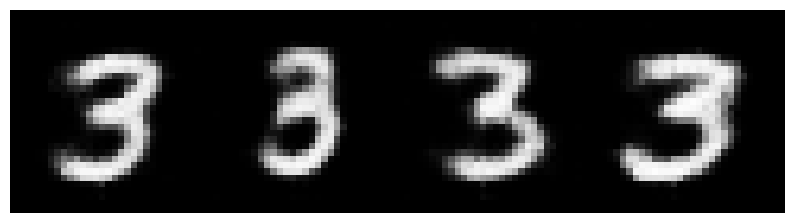

In [36]:
def visualize_generations(model, digit, num_examples):

    # Implement the visualize_generations function
    # You will first encode the digit images into their latent space encodings
    # Then you will sample from the latent space and decode the samples to get the reconstructed images
    # You will then plot the reconstructed images
    # Use the plot_image function to plot the images

    # Get the images of the specified digit
    images = train_dataset.data[train_dataset.targets == digit]
    images = images[:num_examples]
    images = images.unsqueeze(1).float().div(255)
    images = images.to(DEVICE)
    with torch.no_grad():
        mu, logvar = model.encode(images)
        z = model.reparametrize(mu, logvar)
        reconstructed_images = model.decode(z)
        plot_image(reconstructed_images)




digit = 3
num_examples = 4

visualize_generations(model, digit, num_examples)

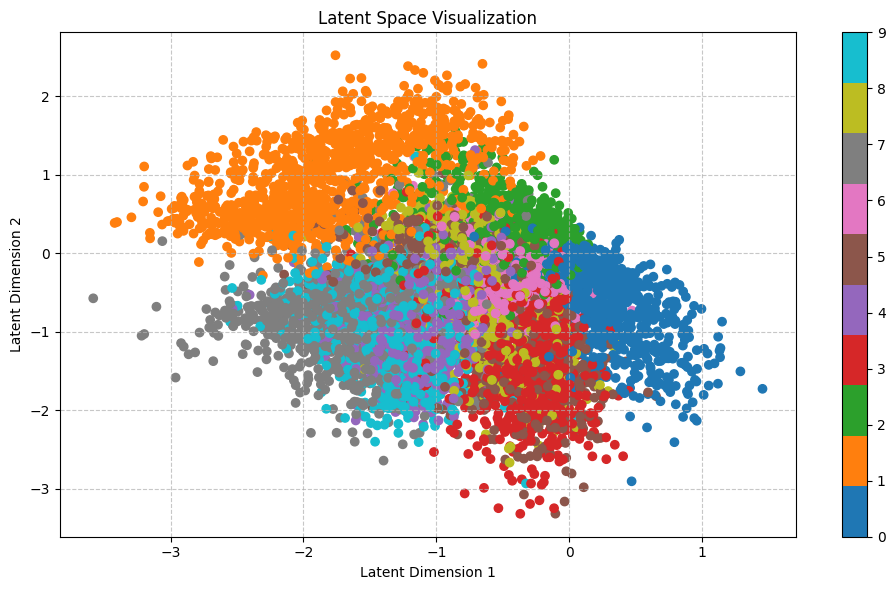

In [39]:
def visualize_latens(dataloader, model):
    # Implement the visualize_latens function
    # Set your model's latent space to 2 and train the model
    # Encode all samples from MNIST test loader to the latent space
    # Plot them using scatter plot to show how your model has been able differentiate between them

    # Load All the test data
    all_data = []
    all_labels = []
    for images, labels in dataloader:
        all_data.append(images)
        all_labels.append(labels)
    all_data = torch.cat(all_data)
    all_labels = torch.cat(all_labels)

    # Encode the data
    all_data = all_data.to(DEVICE)
    with torch.no_grad():
        mu, logvar = model.encode(all_data)
        z = model.reparametrize(mu, logvar)
    z = z.cpu().numpy()

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.scatter(z[:, 0], z[:, 1], c=all_labels, cmap='tab10')
    plt.colorbar()
    plt.xlabel('Latent Dimension 1')
    plt.ylabel('Latent Dimension 2')
    plt.title('Latent Space Visualization')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


visualize_latens(test_loader, model)

# Results (Report)
I trained it for 5 Epochs with latent space dimension of 10. It gave good results. Loss Used was MSE Loss. I also tried Binary Cross Entropy Loss which made results such that slight variations in generation finsihed.

And Question was asked why we output logvar and not variance in VAE. Main reason is that when log(var) can be any real number which is the output of the Neural Netowrk to convert to to a Postive number we exponentiate it so it always remains positive which is necessary for Variance. When I saw the formula for KL Divergence with Standard Normal Distribution, it was clear that we need logvariance. Because we need to calculate the log of variance. So, we output logvariance in VAE. We can also get the variance by taking exponential of logvariance for reparameterization trick.

At last I visualized the latent space with z_dim = 2. It was good to see the clusters of different digits in the latent space.
Noticable thing was that 0, 1, 2 and 7 were somewhat separated from other digits. For other digits such as 3 and 8 they kind of overlapped. 5 was also not well distinguished. Thats why results were also not good for z_dim = 2.

Increasing the z_dim to 10 solved the problem by giving more channels to distinguish the digits.